In [1]:
# Import the packages
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## tspDB Running Example
In this notebook, we showcase the core  functionalities of **tspDB** on a synthetically generated timeseries (The dataset used is provided with the package).

In particular, we show:

**(1)**  How a prediction index is created 

**(2)** How predictions are produced with uncertainity quantification,

**(3)**  How does the predictions and confidence interval compare with the observations and their underlining means.


### To run this test, you need:

**(1)** tspDB installed on a PostgreSQL Database

**(2)** psycopg2, pandas and matplotlib packages installed




## Dataset

The dataset we will be using is synthetically generated from a time-varying mean that is a mixture of harmonics, trend, and a time-varying variance that follows a mixture of harmonics. To perform our test, we first need to download the dataset as follow:

In [5]:
!wget https://aalomar.me/wp-content/uploads/2019/11/MixtureTS_var.csv
!wget https://aalomar.me/wp-content/uploads/2019/11/MixtureTS_var_test.csv

--2019-11-30 17:21:50--  https://aalomar.me/wp-content/uploads/2019/11/MixtureTS_var.csv
Resolving aalomar.me (aalomar.me)... 192.0.78.168, 192.0.78.210
Connecting to aalomar.me (aalomar.me)|192.0.78.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9045119 (8.6M) [application/octet-stream]
Saving to: ‘MixtureTS_var.csv’

MixtureTS_var.csv   100%[===================>]   8.63M  6.41MB/s    in 1.3s    

2019-11-30 17:21:52 (6.41 MB/s) - ‘MixtureTS_var.csv’ saved [9045119/9045119]

--2019-11-30 17:21:52--  https://aalomar.me/wp-content/uploads/2019/11/MixtureTS_var_test.csv
Resolving aalomar.me (aalomar.me)... 192.0.78.210, 192.0.78.168
Connecting to aalomar.me (aalomar.me)|192.0.78.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 912620 (891K) [application/octet-stream]
Saving to: ‘MixtureTS_var_test.csv’

MixtureTS_var_test. 100%[===================>] 891.23K  2.21MB/s    in 0.4s    

2019-11-30 17:21:53 (2.21 MB/s) - ‘MixtureTS_v

Two files are downladed:

**(1)** `MixtureTS_var.csv`: which we will use as our *training* set, which has 100k rows

**(2)** `MixtureTS_var_test.csv`: which we will use as our *test* set for forecasts, which has 10k rows.

Let's inspect the data in the file `mixturets_var.csv` ..




In [6]:
# lets query our table mixturets2 to inspect its column 
data = pd.read_csv("MixtureTS_var.csv")
data.head()

,time,ts,means,ts_9,ts_7,var
0,0,-7.765942,-5.000000,-7.765942,-7.765942,4.986913
1,1,-8.130908,-4.058822,-8.130908,-8.130908,4.928091
2,2,-7.785026,-3.843015,-7.785026,NaN,4.869337
3,3,-5.195306,-3.707296,-5.195306,NaN,4.810716
4,4,0.657312,-3.610115,0.657312,0.657312,4.752293


Our time series data consist of 6 columns, namely:

**(1) time**: (int) this column represent the time index as integers

**(2) means:** (float) Where the underlying mean of the time series is stored. Note that since this data is synthetically generated, we know what is the underlying mean of the generation process

**(3) ts:** (float) Where the observation of the time series are stored

**(4) ts_7:** (float) Where 70% the observation of the time series are stored, and 30 % are artificially masked

**(5) ts_9:** (float) Where 90% the observation of the time series are stored, and 10 % are artificially masked

**(6) var:** (float) Where the underlying time-varying variance of our time series is stored



In this example, we will use the `ts_7` column, where 30% of the data are missing, and we will estimate the imputation and forecasting accuracy by comparing them with the real underlying mean. 

First, we will upload the first dataset into your PostgreSQL database. To do so, we will first set up connection to the database.

## DB connection

**Here, you need to fill in your database connection information below**

In [7]:
## fill your db information
database = 'querytime_test'
user = 'postgres'
password = '0505'
host = 'localhost'
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)
conn = psycopg2.connect(conn_string)

## Crate Time Series Table
Now, we will load the dataset into your database. We will store it in table `synth_data`

In [8]:
conn = psycopg2.connect(conn_string)

cur = conn.cursor()

# Drop the table if it already exists
cur.execute("DROP table IF EXISTS synth_data;")

# load data into Pandas dataframe
df = pd.read_csv("MixtureTS_var.csv")

# only select the time column and `ts_7' column
df_db = df[['time', 'ts_7']]

# create table
create_table = "CREATE  TABLE synth_data(\
   time int PRIMARY KEY,\
   ts_7 double precision);"
cur.execute(create_table)

# Populate table using pandas
output = io.StringIO()
df_db.to_csv(output, sep='\t', header=False, index=False)
output.seek(0)
cur.copy_from(output, 'synth_data', null="")

# close connection
conn.commit()
conn.close()
print('Table created and Loaded')



Table created and Loaded


Now the table is loaded into the database. Let's check the first 10 entries of the table

In [9]:
# lets query our table mixturets2 to inspect its column 
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from synth_data limit 10;", conn)
conn.close()
df

,time,ts_7
0,0,-7.765942
1,1,-8.130908
2,2,NaN
3,3,NaN
4,4,0.657312
5,5,NaN
6,6,NaN
7,7,-1.193333
8,8,NaN
9,9,-3.344865


Note that the `ts_7` column has several of its entries missing. After creating the prediction index, we will be able to impute these values, as well as forecast future values!  And that's what we would do next


## Create prediction index


Now, we will create a predictive index which we will call 'pindex1' on the column ts_7 (which has 30% of its entries missing) The creatin of this index allows for retreiving predicted values for entries that are: 

**(1)** At a future time step (i.e. forecasting), 

**(2)** Missing/corrupted by noise (i.e. imputation)

In addition to that, it will also estimate the underlying time-varying variance of the time series, which allow users to produce upper and lower bound for their prediction.  

Let's now build out pindex on relation **synth_data**, using the time column **time** to predict values for column **ts_7**

In [122]:
conn.close()
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('synth_data', 'time','{"ts_7"}','pindex');""")
conn.commit()
conn.close()

With that, the prediction indiex *is built*. Now lets list the predictive indices that has been built so far using the function ``list_pindices()``. 

Note that there might be others pindices built if you used the `tspdb_test(`) function when installing the package.


In [163]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from tspdb.pindices_stats;", conn)
df

,index_name,column_name,number_of_observations,number_of_trained_models,imputation_score,forecast_score,test_forecast_score
0,p2,ts,99999,1,1.000000,1.000000,None
1,p1,ts,100000,1,1.000000,1.000000,None
2,pindex_test,ts_7,100001,1,0.949537,0.947728,None
3,pindex,ts_7,100000,1,0.951167,0.948163,None
4,pindex_1,MT_001,26303,1,0.911072,0.871146,None
...,...,...,...,...,...,...,...
104,pindex_electricity,MT_096,26303,2,0.931513,0.897261,None
105,pindex_electricity,MT_097,26303,2,0.971256,0.953703,None
106,pindex_electricity,MT_098,26303,2,0.983813,0.978460,None
107,pindex_electricity,MT_099,26303,2,0.986353,0.976088,None


We see that our index has been created. Now lets list the in-sample score ($R^2$) of our predictive indices using the function `pindicse_stat()`

In [116]:
df = pd.read_sql_query("select * from pindices_stat();", conn)
df

,index_name,column_name,number_of_observations,number_of_trained_models,imputation_score,forecast_score,test_forecast_score
0,p2,ts,99999,1,1.000000,1.000000,None
1,p1,ts,100000,1,1.000000,1.000000,None
2,pindex_test,ts_7,100001,1,0.949537,0.947728,None
3,pindex,ts_7,100000,1,0.951179,0.948205,None


With that, we are ready to use  **predict queries**! 

## Prediction Queries
Let's now use the prediction function and range prediction function. Specifically, we will start by showcasing the imputation capabilities of **tspdb**, and then we will move on to forecasting future values.



### Imputation 

#### Simple example

Before imputing the data, let's look at the value of `ts_7` at time 19 in the database. 

In [146]:
df = pd.read_sql_query("select * from synth_data where time = 1000;", conn)
df

,time,ts_7
0,1000,None


We can see that the value is missing at time 1. Let's check what was the underlying mean of our data at time one, which we can get from the data file

In [147]:
data[data['time'] == 1000]['means']

1000    9.081748
Name: means, dtype: float64

Idealy, we would like our prediction index to *predict* the value `9.081748` for `ts_7` at time = 1. Let's see what the index produces using the function `predict()`

In [148]:
df = pd.read_sql_query("select * from predict('synth_data','ts_7',1000,'pindex');", conn)
df

,prediction,lb,ub
0,8.562329,3.289954,13.834704


The predicted value is `8.5623` with an lower bound of `3.29` and upper bound of `13.834`. The confidence interval is fairly big! which indicate that the index estimate a fairly high variance at this point. Let's check the underlying variance from our data table. 

In [149]:
data[data['time'] == 1000]['var']

1000    7.848476
Name: var, dtype: float64

Which is indeed a big variance that justifies the big confidence interval.

Let's now use the `predict_range()` function to plot the first 100 imputed points, along with the observations `ts_7` and the underlying latent mean.

<IPython.core.display.Javascript object>


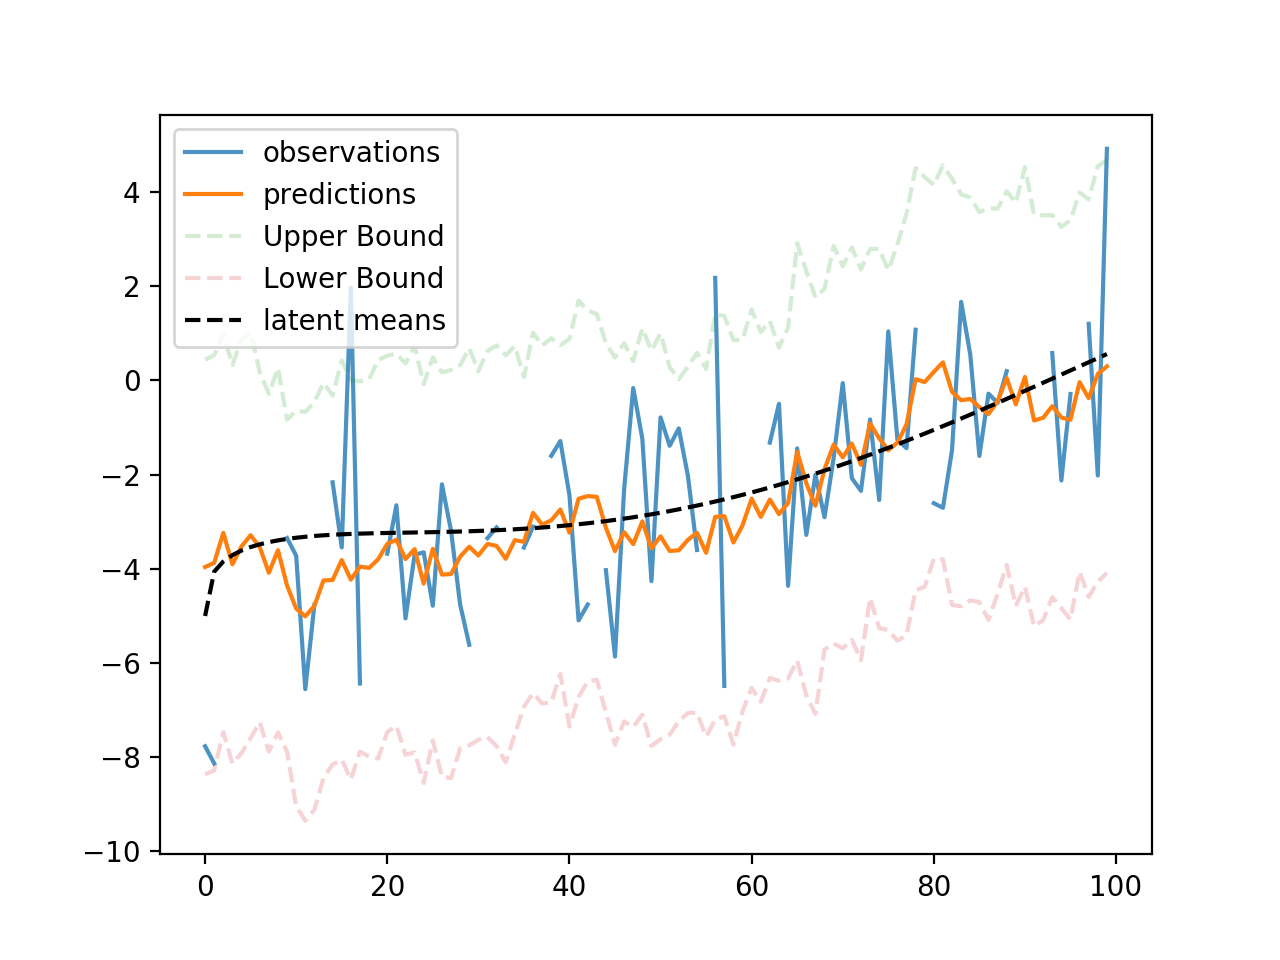

In [150]:
%matplotlib notebook
df = pd.read_sql_query("select * from predict_range('synth_data','ts_7',0,99,'pindex');", conn)
df['time'] = np.arange(100)
plt.plot(df['time'], data['ts_7'][:100], label = 'observations', alpha = 0.8)
plt.plot(df['time'], df['prediction'], label = 'predictions')
plt.plot(df['time'], df['ub'], '--',label = 'Upper Bound', alpha = 0.2)
plt.plot(df['time'], df['lb'], '--',label = 'Lower Bound', alpha = 0.2)
plt.plot(df['time'], data['means'][:100],'--k', label = 'latent means', alpha = 1.0)
# plt.plot(df['time'], df['latent_var'],'--', label = 'latent variance', alpha = 0.4)
plt.legend()

Note that the predictions closely follow the underlying mean, even though 30% of the data is missing. Note also that the upper and lower bound estimates almost always envelop the observations. 

#### imputation Accuracy
To estimate the accuracy of our predictions, let's predict the first 1000 points and compare the predictions to the real underlying mean.  

<IPython.core.display.Javascript object>


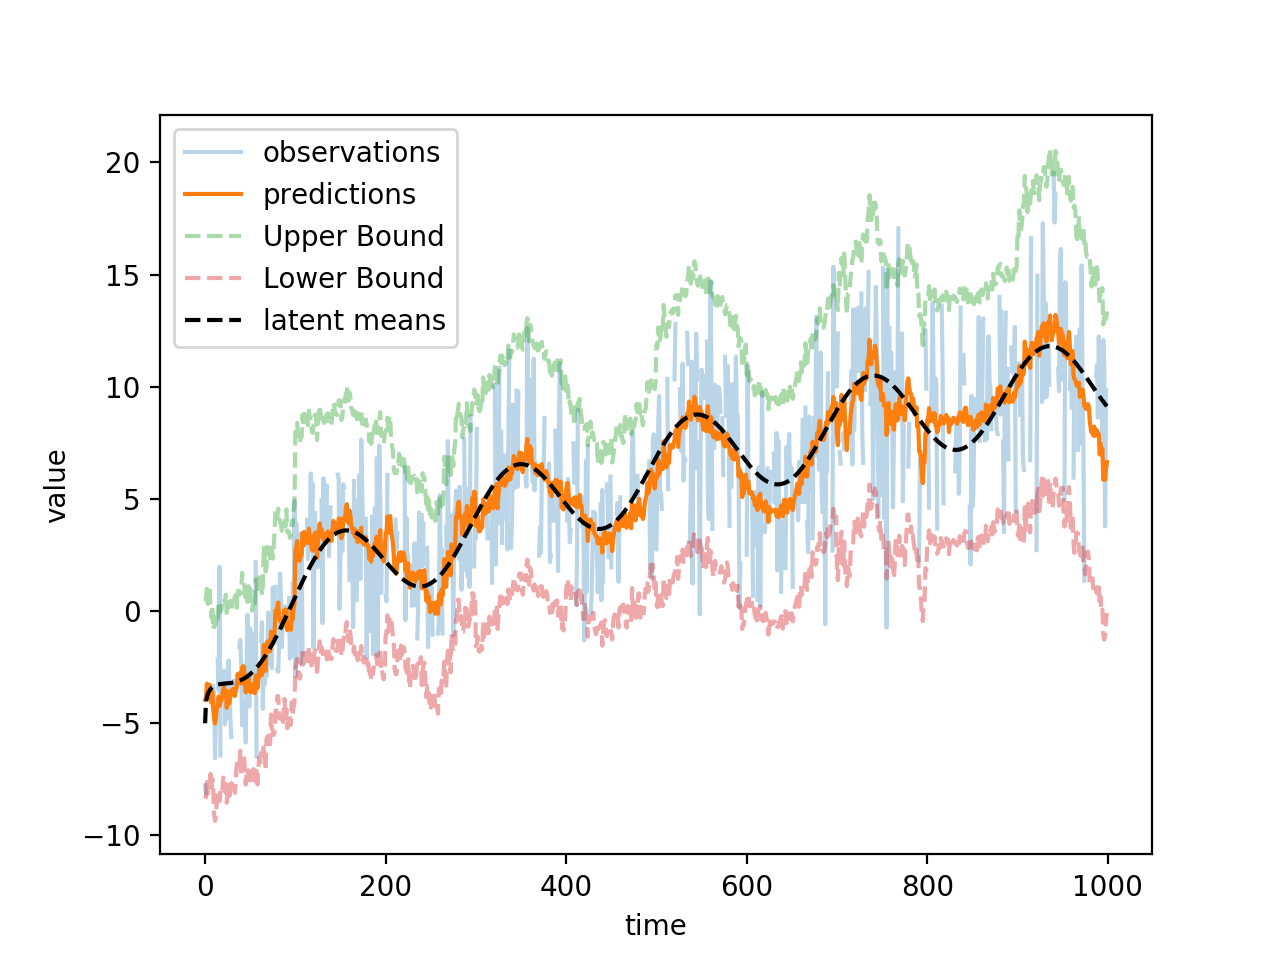

In [158]:

%matplotlib notebook
N = 1000
query = "select * from  predict_range('synth_data','ts_7',0,%s,'pindex');"%(N-1)
df = pd.read_sql_query(query, conn)
df['time'] = np.arange(N)
plt.plot(df['time'], data['ts_7'][:N], label = 'observations', alpha = 0.3)
plt.plot(df['time'], df['prediction'], label = 'predictions')
plt.plot(df['time'], df['ub'], '--',label = 'Upper Bound', alpha = 0.4)
plt.plot(df['time'], df['lb'], '--',label = 'Lower Bound', alpha = 0.4)
plt.plot(df['time'], data['means'][:N],'--k', label = 'latent means', alpha = 1.0)
plt.ylabel('value')
plt.xlabel('time')
# plt.plot(df['time'], df['latent_var'],'--', label = 'latent variance', alpha = 0.4)
plt.legend()

The $R^2$ and MSE are:

In [159]:
print ('imputation accuracy (R2):',r2_score(data['means'][:N],df['prediction']))
print ('imputation accuracy (MSE):',np.mean(np.square(data['means'][:N]-df['prediction'])))

imputation accuracy (R2): 0.9511898910458023
imputation accuracy (MSE): 0.7408070792473759


**Now, we will move on to forecasting future values!**

## Forecast Example

In this example, we will forecast the next 100 points in our time series. That is, we will predict the value of `ts_7` from time = 100001 to time = 100100. We will then compare the result with the underlying mean.

First we will load the test dataset to compare our predictions with it

In [153]:
data_test = pd.read_csv('MixtureTS_var_test.csv').iloc[:50]
means = data['means']

Now we will produce the forecast for the next hundred points using `predict_range`

<IPython.core.display.Javascript object>


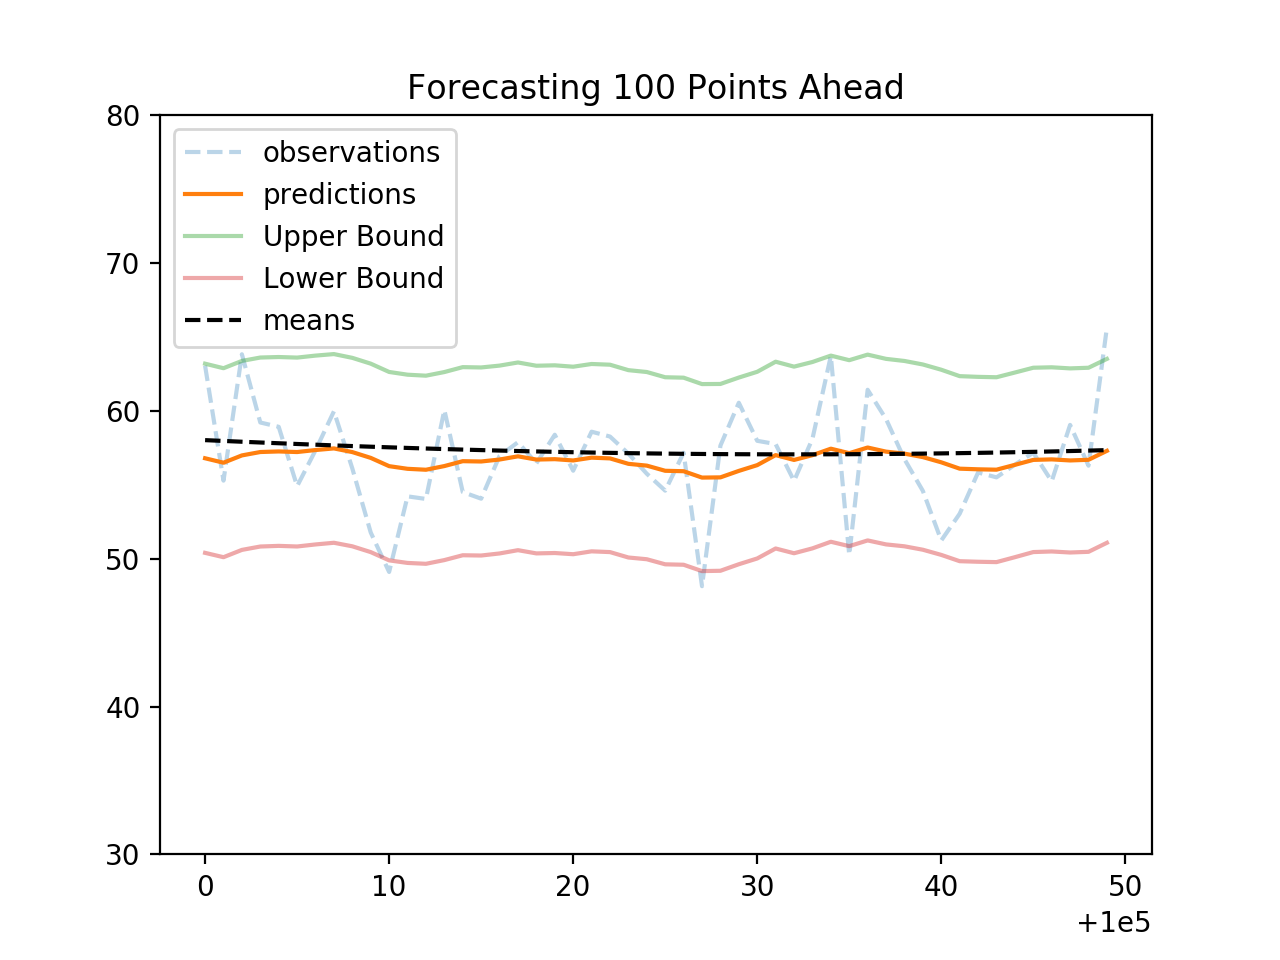

In [156]:
df = pd.read_sql_query("select * from predict_range('synth_data','ts_7',100001,100050,'pindex');", conn)
plt.figure()
plt.plot(data_test['time'], data_test['ts'],'--', label = 'observations', alpha = 0.3)
plt.plot(data_test['time'], df['prediction'], label = 'predictions')
plt.plot(data_test['time'], df['ub'], label = 'Upper Bound', alpha = 0.4)
plt.plot(data_test['time'], df['lb'], label = 'Lower Bound', alpha = 0.4)
plt.plot(data_test['time'], data_test['means'],'--k', label = 'means', alpha = 1.0)

plt.ylim([30,80])
plt.title('Forecasting 100 Points Ahead')
# plt.plot(df['time'], df['var'],'--', label = 'latent variance', alpha = 0.4)
plt.legend()

The MSE error is:

In [157]:
print ('Forecasting accuracy (MSE):',np.mean(np.square(data_test['means'][:N]-df['prediction'])))

Forecasting accuracy (MSE): 0.6760678205978973
